In [7]:
!pip install cupy-cuda110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 4.2 MB/s eta 0:00:00


In [18]:
import cv2
import time
import numpy as np
from numba import jit
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from scipy.spatial.distance import cdist
from skimage.restoration import denoise_bilateral
from skimage import img_as_float, img_as_ubyte, filters
from skimage.transform import hough_line, hough_line_peaks

In [13]:
def bilateral_filter_manual(image, filter_size, spatial_variance, gray_scale_variance):
  """
  Apply bilateral filtering to an input image using manual calculation.

  Args:
    image (numpy.array): Input image
    filter_size (int): Size of the bilateral filter
    spatial_variance (float): Spatial variance for the filter
    gray_scale_variance (float): Gray scale variance for the filter
  Returns:
    numpy.array: Bilaterally filtered image
  """

  height, width = image.shape
  filtered_image = np.zeros_like(image)
  offset = filter_size // 2
  
  spatial_kernel = np.zeros((filter_size, filter_size))
  for i in range(filter_size):
    for j in range(filter_size):
      spatial_kernel[i, j] = np.exp(-((i - offset) ** 2 + (j - offset) ** 2) / (2 * spatial_variance))

  for i in range(offset, height - offset):
    for j in range(offset, width - offset):
      region = image[i - offset:i + offset + 1, j - offset:j + offset + 1]
      intensity_kernel = np.exp(-(region - image[i, j])**2 / (2 * gray_scale_variance))

      bilateral_kernel = spatial_kernel * intensity_kernel
      filtered_image[i, j] = np.sum(region * bilateral_kernel) / np.sum(bilateral_kernel)

  return filtered_image

def bilateral_filter_cv2(image, filter_size, spatial_variance, gray_scale_variance):
  """
  Apply bilateral filtering to an input image using OpenCV.

  Args:
    image (numpy.array): Input image
    filter_size (int): Size of the bilateral filter
    spatial_variance (float): Spatial variance for the filter
    gray_scale_variance (float): Gray scale variance for the filter
  Returns:
    numpy.array: Bilaterally filtered image
  """
  
  return cv2.bilateralFilter(image, filter_size, gray_scale_variance, gray_scale_variance)

def bilateral_filter_skimage(image, filter_size, spatial_variance, gray_scale_variance):
  """
  Apply bilateral filtering to an input image using skimage.

  Args:
    image (numpy.array): Input image
    filter_size (int): Size of the bilateral filter
    spatial_variance (float): Spatial variance for the filter
    gray_scale_variance (float): Gray scale variance for the filter
  Returns:
    numpy.array: Bilaterally filtered image
  """
  
  float_image = img_as_float(image)
  filtered_image = denoise_bilateral(float_image, sigma_color=gray_scale_variance, sigma_spatial=spatial_variance, multichannel=False)
  
  return img_as_ubyte(filtered_image)

In [14]:
def test_the_bilateral_filter_pipeline(image):

  filter_methods = ['manual', 'cv2', 'skimage']
  test_cases = [
    ("No filtering in the spatial domain", 1, 75),
    ("No filtering in the gray scale domain", 5, 0.001),
    ("Extreme filtering in the spatial domain", 25, 75),
    ("Extreme filtering in the gray scale domain", 5, 300),
    ("Moderate filtering", 9, 150)
  ]

  fig, axs = plt.subplots(len(test_cases), len(filter_methods), figsize=(15, 15))
  
  for i, (title, filter_size, gray_scale_variance) in enumerate(test_cases):
    print(f'Start testing case: {i} \n {title}')
    for k, filter_method in enumerate(filter_methods):
      start_time = time.time()
      if filter_method == 'manual':
        filtered_image = bilateral_filter_manual(image, filter_size, gray_scale_variance, gray_scale_variance)
      
      elif filter_method == 'cv2':
        filtered_image = bilateral_filter_cv2(image, filter_size, gray_scale_variance, gray_scale_variance)
      
      elif filter_method == 'skimage':
        filtered_image = bilateral_filter_skimage(image, filter_size, gray_scale_variance, gray_scale_variance)
      
      end_time = time.time()
      elapsed_time = end_time - start_time

      axs[i, k].imshow(filtered_image, cmap='gray')
      axs[i, k].set_title(f'{title}\n{filter_method.capitalize()}: {elapsed_time:.3f}s')
      axs[i, k].axis('off')

  plt.tight_layout()
  plt.show()

Start testing case: 0 



<ipython-input-13-eb0864b99433>:64: FutureWarning: `multichannel` is a deprecated argument name for `denoise_bilateral`. It will be removed in version 1.0. Please use `channel_axis` instead.
  filtered_image = denoise_bilateral(float_image, sigma_color=gray_scale_variance, sigma_spatial=spatial_variance, multichannel=False)


Start testing case: 1 



<ipython-input-13-eb0864b99433>:50: RuntimeWarning: overflow encountered in exp
  intensity_kernel = np.exp(-(region - image[i, j])**2 / (2 * gray_scale_variance))
<ipython-input-13-eb0864b99433>:52: RuntimeWarning: invalid value encountered in multiply
  bilateral_kernel = spatial_kernel * intensity_kernel


Start testing case: 2 

Start testing case: 3 

Start testing case: 4 



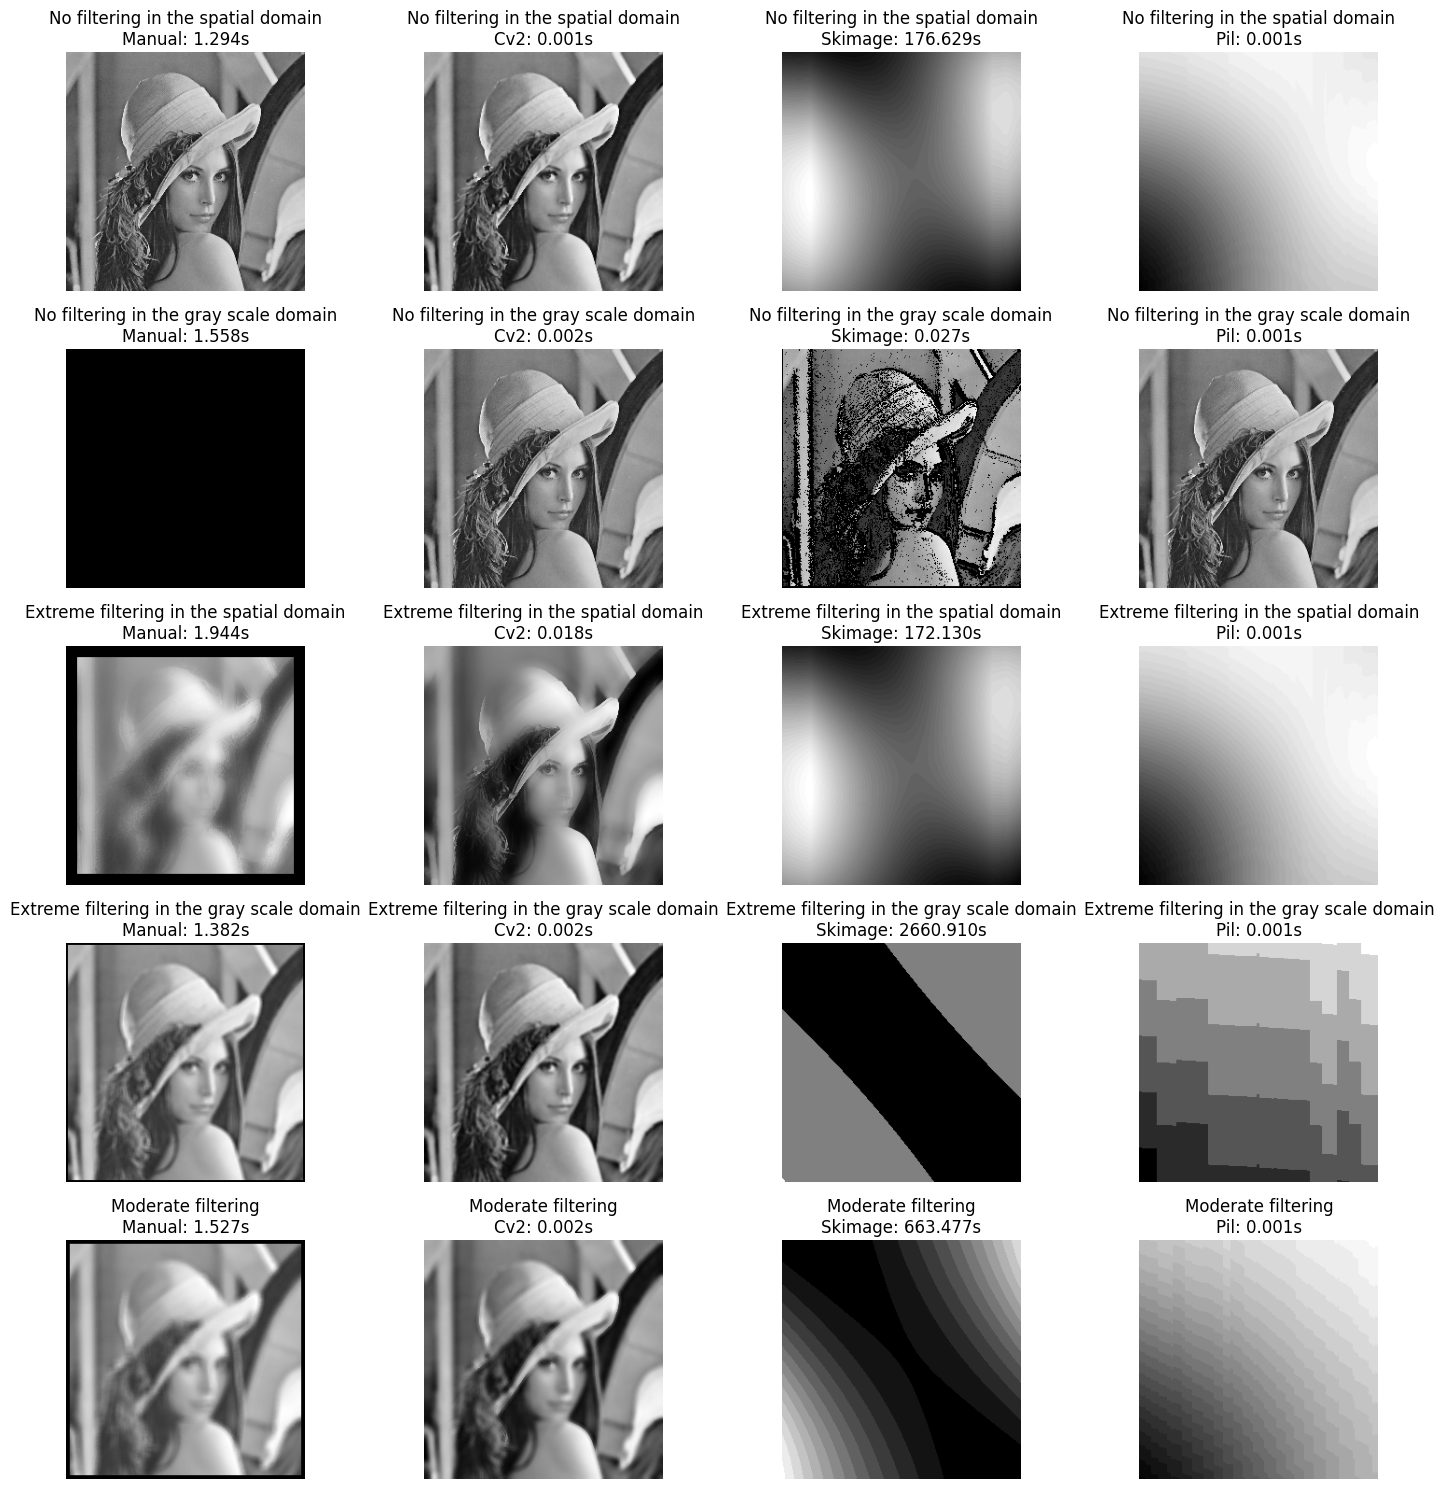

In [15]:
# Load your image as a grayscale image
lena_path = '/content/lena.png'

image = cv2.imread(lena_path, cv2.IMREAD_GRAYSCALE)
test_the_bilateral_filter_pipeline(image)

In [22]:
def create_sobel_kernel(size):
  """
  Create Sobel kernels for x and y directions.

  Args:
    size (int): Size of the Sobel kernel (odd number).      
  Returns:
    tuple: Two numpy arrays representing the Sobel kernels for x and y directions.
  """
  center = size // 2
  kernel_x = np.zeros((size, size), dtype=np.float32)
  kernel_y = np.zeros((size, size), dtype=np.float32)

  for i in range(size):
    for j in range(size):
      diff = j - center
      kernel_x[i, j] = -diff if i == center else 0
      kernel_y[i, j] = diff if j == center else 0

  return kernel_x, kernel_y

def sobel_manual(image, kernel_size):
  """
  Apply the Sobel filter manually to an input image.

  Args:
    image (numpy.array): Input image
    kernel_size (int): Size of the Sobel kernel
  Returns:
    tuple: Two numpy arrays representing the derivative images in x and y directions.
  """
  sobel_x, sobel_y = create_sobel_kernel(kernel_size)
  
  dx = ndimage.convolve(image, sobel_x)
  dy = ndimage.convolve(image, sobel_y)
  
  return dx, dy

def sobel_cv2(image, kernel_size):
  """
  Apply the Sobel filter using OpenCV to an input image.

  Args:
    image (numpy.array): Input image
    kernel_size (int): Size of the Sobel kernel
  Returns:
    tuple: Two numpy arrays representing the derivative images in x and y directions.
  """

  dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
  dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size)
  
  return dx, dy

def sobel_skimage(image, kernel_size):
  """
  Apply the Sobel filter using skimage to an input image.

  Args:
    image (numpy.array): Input image
    kernel_size (int): Size of the Sobel kernel
  Returns:
    tuple: Two numpy arrays representing the derivative images in x and y directions.
  """
  
  dx = filters.sobel_h(image)
  dy = filters.sobel_v(image)
  
  return dx, dy

def create_laplacian_kernel(size):
  """
  Create a Laplacian kernel.

  Args:
    size (int): Size of the Laplacian kernel (odd number).
  Returns:
    numpy.array: A numpy array representing the Laplacian kernel.
  """
  
  center = size // 2
  kernel = np.zeros((size, size), dtype=np.float32)

  for i in range(size):
    for j in range(size):
      dist = abs(i - center) + abs(j - center)
      kernel[i, j] = -4 if dist == 0 else 1 if dist == 1 else 0

  return kernel

def laplacian_manual(image, kernel_size):
  """
  Apply the Laplacian filter manually to an input image.

  Args:
    image (numpy.array): Input image
    kernel_size (int): Size of the Laplacian kernel
  Returns:
    numpy.array: Output image after applying the Laplacian filter.
  """
  
  laplacian_kernel = create_laplacian_kernel(kernel_size)

  return ndimage.convolve(image, laplacian_kernel)


def laplacian_cv2(image, kernel_size):
  """
  Apply the Laplacian filter using OpenCV to an input image.

  Args:
    image (numpy.array): Input image
    kernel_size (int): Size of the Laplacian kernel
  Returns:
    numpy.array: Output image after applying the Laplacian filter.
  """

  return cv2.Laplacian(image, cv2.CV_64F, ksize=kernel_size)

def laplacian_skimage(image, kernel_size):
  """
  Apply the Laplacian filter using skimage to an input image.

  Args:
    image (numpy.array): Input image
    kernel_size (int): Size of the Laplacian kernel
  Returns:
    numpy.array: Output image after applying the Laplacian filter.
  """
  return filters.laplace(image, ksize=kernel_size)

def create_log_kernel(size, sigma):
  """
  Create a Laplacian of Gaussian (LoG) kernel.

  Args:
    size (int): Size of the LoG kernel (odd number).
    sigma (float): Standard deviation of the Gaussian function.
  Returns:
    numpy.array: A numpy array representing the LoG kernel.
  """
  
  center = size // 2
  x, y = np.meshgrid(np.arange(-center, center + 1), np.arange(-center, center + 1))
  normal = 1 / (2.0 * np.pi * sigma**2)
  kernel = normal * np.exp(-(x**2 + y**2) / (2.0*sigma**2))
  kernel_laplace = kernel * (x**2 + y**2 - 2*sigma**2) / sigma**4

  return kernel_laplace

def laplacian_of_gaussian_manual(image, kernel_size, sigma):
  """
  Apply the Laplacian of Gaussian (LoG) filter manually to an input image.

  Args:
    image (numpy.array): Input image
    kernel_size (int): Size of the LoG kernel
    sigma (float): Standard deviation of the Gaussian function
  Returns:
    numpy.array: Output image after applying the LoG filter.
  """
  
  kernel_laplace = create_log_kernel(kernel_size, sigma)

  return ndimage.convolve(image, kernel_laplace)

def laplacian_of_gaussian_cv2(image, kernel_size, sigma):
  """
  Apply the Laplacian of Gaussian (LoG) filter using OpenCV to an input image.

  Args:
    image (numpy.array): Input image
    kernel_size (int): Size of the LoG kernel
    sigma (float): Standard deviation of the Gaussian function
  Returns:
    numpy.array: Output image after applying the LoG filter.
  """
  
  blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
  
  return cv2.Laplacian(blurred_image, cv2.CV_64F, ksize=kernel_size)

def laplacian_of_gaussian_skimage(image, kernel_size, sigma):
  """
  Apply the Laplacian of Gaussian (LoG) filter using skimage to an input image.

  Args:
    image (numpy.array): Input image
    kernel_size (int): Size of the LoG kernel
    sigma (float): Standard deviation of the Gaussian function
  Returns:
    numpy.array: Output image after applying the LoG filter.
  """
  
  blurred_image = filters.gaussian(image, sigma=sigma)
  
  return filters.laplace(blurred_image, ksize=kernel_size)

def create_gaussian_derivative_kernels(size, sigma):
  """
  Create Gaussian derivative kernels for x and y directions.

  Args:
    size (int): Size of the Gaussian derivative kernel (odd number).
    sigma (float): Standard deviation of the Gaussian function.
  Returns:
    tuple: Two numpy arrays representing the Gaussian derivative kernels for x and y directions.
  """
  
  center = size // 2
  x, y = np.meshgrid(np.arange(-center, center + 1), np.arange(-center, center + 1))
  normal = 1 / (2.0 * np.pi * sigma**2)
  kernel_x = normal * np.exp(-(x**2 + y**2) / (2.0*sigma**2)) * (-x / sigma**2)
  kernel_y = normal * np.exp(-(x**2 + y**2) / (2.0*sigma**2)) * (-y / sigma**2)

  return kernel_x, kernel_y

def gaussian_derivative_manual(image, kernel_size, sigma):
  """
  Apply the Gaussian derivative filter manually to an input image.

  Args:
    image (numpy.array): Input image
    kernel_size (int): Size of the Gaussian derivative kernel
    sigma (float): Standard deviation of the Gaussian function
  Returns:
    tuple: Two numpy arrays representing the derivative images in x and y directions.
  """

  kernel_x, kernel_y = create_gaussian_derivative_kernels(kernel_size, sigma)

  dx = ndimage.convolve(image, kernel_x)
  dy = ndimage.convolve(image, kernel_y)
  
  return dx, dy

def gaussian_derivative_cv2(image, kernel_size, sigma):
  """
  Apply the Gaussian derivative filter using OpenCV to an input image.

  Args:
    image (numpy.array): Input image
    kernel_size (int): Size of the Gaussian derivative kernel
    sigma (float): Standard deviation of the Gaussian function
  Returns:
    tuple: Two numpy arrays representing the derivative images in x and y directions.
  """
  
  kx, ky = cv2.getDerivKernels(1, 1, kernel_size)
  kx = np.transpose(kx / sigma)
  ky = ky / sigma
  dx = cv2.filter2D(image, -1, kx)
  dy = cv2.filter2D(image, -1, ky)
  
  return dx, dy

def gaussian_derivative_skimage(image, kernel_size, sigma):
  """
  Apply the Gaussian derivative filter using skimage to an input image.

  Args:
    image (numpy.array): Input image
    kernel_size (int): Size of the Gaussian derivative kernel
    sigma (float): Standard deviation of the Gaussian function
  Returns:
    tuple: Two numpy arrays representing the derivative images in x and y directions.
  """
  
  blurred_image = filters.gaussian(image, sigma=sigma)
  dx, dy = np.gradient(blurred_image)
  
  return dx, dy

In [19]:
def test_edge_detection(image):
  # Example kernel sizes and sigma values
  kernel_sizes = [3, 5]
  sigmas = [1.0, 2.0]

  for kernel_size in kernel_sizes:
    for sigma in sigmas:
      # Sobel Filter
      sobel_dx_manual, sobel_dy_manual = sobel_manual(image, kernel_size)
      sobel_dx_cv2, sobel_dy_cv2 = sobel_cv2(image, kernel_size)
      sobel_dx_skimage, sobel_dy_skimage = sobel_skimage(image, kernel_size)

      # Laplacian
      laplacian_manual_result = laplacian_manual(image, kernel_size)
      laplacian_cv2_result = laplacian_cv2(image, kernel_size)
      laplacian_skimage_result = laplacian_skimage(image, kernel_size)

      # Laplacian of Gaussian
      log_manual_result = laplacian_of_gaussian_manual(image, kernel_size, sigma)
      log_cv2_result = laplacian_of_gaussian_cv2(image, kernel_size, sigma)
      log_skimage_result = laplacian_of_gaussian_skimage(image, kernel_size, sigma)

      # Gaussian Derivative
      gaussian_dx_manual, gaussian_dy_manual = gaussian_derivative_manual(image, kernel_size, sigma)
      gaussian_dx_cv2, gaussian_dy_cv2 = gaussian_derivative_cv2(image, kernel_size, sigma)
      gaussian_dx_skimage, gaussian_dy_skimage = gaussian_derivative_skimage(image, kernel_size, sigma)

      # Display the results using subplots
      fig, axs = plt.subplots(4, 3, figsize=(15, 20))

      # Sobel Filter results
      axs[0, 0].imshow(sobel_dx_manual, cmap='gray')
      axs[0, 0].set_title('Sobel Manual DX')
      axs[0, 1].imshow(sobel_dx_cv2, cmap='gray')
      axs[0, 1].set_title('Sobel CV2 DX')
      axs[0, 2].imshow(sobel_dx_skimage, cmap='gray')
      axs[0, 2].set_title('Sobel skimage DX')

      # Laplacian results
      axs[1, 0].imshow(laplacian_manual_result, cmap='gray')
      axs[1, 0].set_title('Laplacian Manual')
      axs[1, 1].imshow(laplacian_cv2_result, cmap='gray')
      axs[1, 1].set_title('Laplacian CV2')
      axs[1, 2].imshow(laplacian_skimage_result, cmap='gray')
      axs[1, 2].set_title('Laplacian skimage')

      # Laplacian of Gaussian results
      axs[2, 0].imshow(log_manual_result, cmap='gray')
      axs[2, 0].set_title('LoG Manual')
      axs[2, 1].imshow(log_cv2_result, cmap='gray')
      axs[2, 1].set_title('LoG CV2')
      axs[2, 2].imshow(log_skimage_result, cmap='gray')
      axs[2, 2].set_title('LoG skimage')
      # Gaussian Derivative results
      axs[3, 0].imshow(gaussian_dx_manual, cmap='gray')
      axs[3, 0].set_title('Gaussian Derivative Manual DX')
      axs[3, 1].imshow(gaussian_dx_cv2, cmap='gray')
      axs[3, 1].set_title('Gaussian Derivative CV2 DX')
      axs[3, 2].imshow(gaussian_dx_skimage, cmap='gray')
      axs[3, 2].set_title('Gaussian Derivative skimage DX')

      # Adjusting subplots
      for ax in axs.flat:
        ax.label_outer()
        ax.axis('off')

      plt.suptitle(f'Kernel size: {kernel_size}, Sigma: {sigma}')
      plt.show()


In [21]:
# Load your image as a grayscale image
lena_path = '/content/lena.png'

image = cv2.imread(lena_path, cv2.IMREAD_GRAYSCALE)
test_edge_detection(image)

Output hidden; open in https://colab.research.google.com to view.

In [85]:
def load_image(file_path):
  return cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2GRAY)

def display_image(image, title=""):
  plt.imshow(image)
  plt.title(title)
  plt.axis("off")
  plt.show()

def hough_transform_manual(image, rho_resolution=1, theta_resolution=np.pi/180, threshold=100):
  height, width = image.shape
  diagonal = int(np.sqrt(height**2 + width**2))
  thetas = np.arange(0, 180, theta_resolution * 180 / np.pi)
  rhos = np.arange(-diagonal, diagonal, rho_resolution)

  accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
  y_idxs, x_idxs = np.nonzero(image)

  for i in range(len(x_idxs)):
    x = x_idxs[i]
    y = y_idxs[i]

    for j in range(len(thetas)):
      rho = int(x * np.cos(thetas[j] * np.pi / 180) + y * np.sin(thetas[j] * np.pi / 180))
      accumulator[rho, j] += 1

  lines = []
  for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
      if accumulator[y, x] > threshold:
        lines.append((rhos[y], thetas[x]))

  return lines

def hough_transform_cv2(image, rho_resolution=1, theta_resolution=np.pi/180, threshold=100):

  lines = cv2.HoughLines(image, rho_resolution, theta_resolution, threshold)
  
  return [np.array([line[0][0], line[0][1]]) for line in lines]

def hough_transform_skimage(image, rho_resolution=1, theta_resolution=np.pi/180, threshold=100):

  accumulator, thetas, rhos = hough_line(image)
  accumulator_threshold = threshold * accumulator.max() / 100
  lines = hough_line_peaks(accumulator, thetas, rhos, threshold=accumulator_threshold)

  return [np.array([rho, theta]) for rho, theta in zip(rhos[lines[1].astype(int)], thetas[lines[0].astype(int)])]

def plot_lines(ax, image, lines, title):
  for line in lines:
    rho, theta = line[:2]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    ax.plot((x1, x2), (y1, y2), lw=2)

  ax.imshow(image, cmap=plt.cm.gray)
  ax.set_title(title)
  ax.set_axis_off()

In [53]:
def test_hough_transform(image, rho_resolution=1, theta_resolution=np.pi/180, threshold=100):
  
  start_time = time.time()
  lines_manual = hough_transform_manual(image, rho_resolution, theta_resolution, threshold)
  manual_time = time.time() - start_time

  start_time = time.time()
  lines_cv2 = hough_transform_cv2(image, rho_resolution, theta_resolution, threshold)
  cv2_time = time.time() - start_time

  start_time = time.time()
  lines_skimage = hough_transform_skimage(image, rho_resolution, theta_resolution, threshold)
  skimage_time = time.time() - start_time

  return lines_manual, manual_time, lines_cv2, cv2_time, lines_skimage, skimage_time

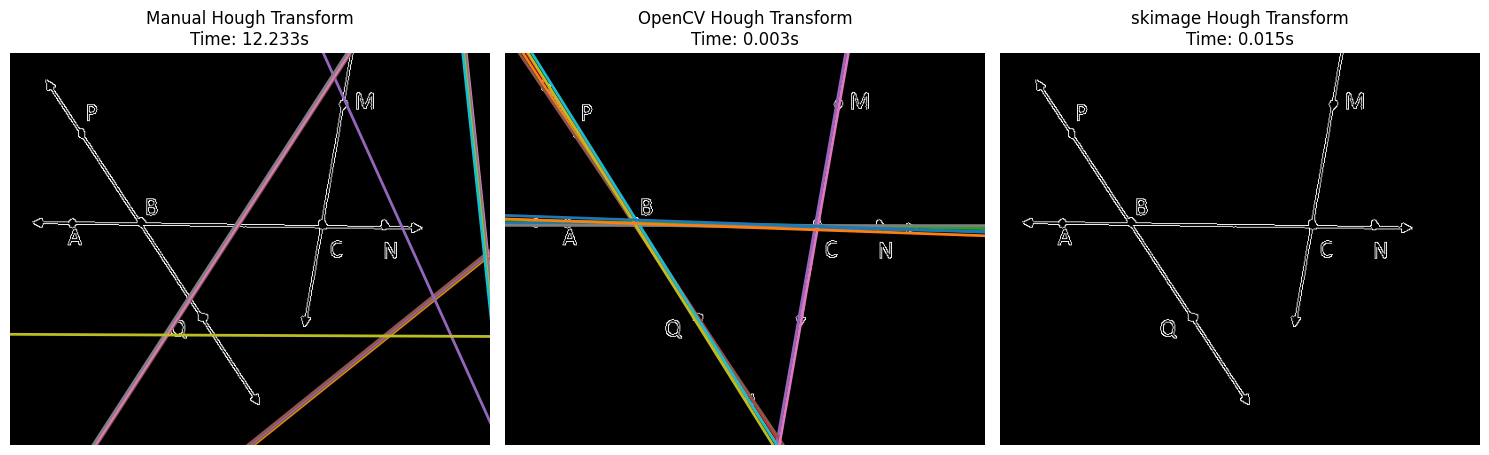

In [74]:
file_path = "/content/line1.jpg"
gray_image = load_image(file_path)

edge_image = cv2.Canny(gray_image, 100, 200)

lines_manual, manual_time, lines_cv2, cv2_time, lines_skimage, skimage_time = test_hough_transform(edge_image)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

plot_lines(axes[0], edge_image, lines_manual, f"Manual Hough Transform\nTime: {manual_time:.3f}s")
plot_lines(axes[1], edge_image, lines_cv2, f"OpenCV Hough Transform\nTime: {cv2_time:.3f}s")
plot_lines(axes[2], edge_image, lines_skimage, f"skimage Hough Transform\nTime: {skimage_time:.3f}s")

plt.tight_layout()
plt.show()

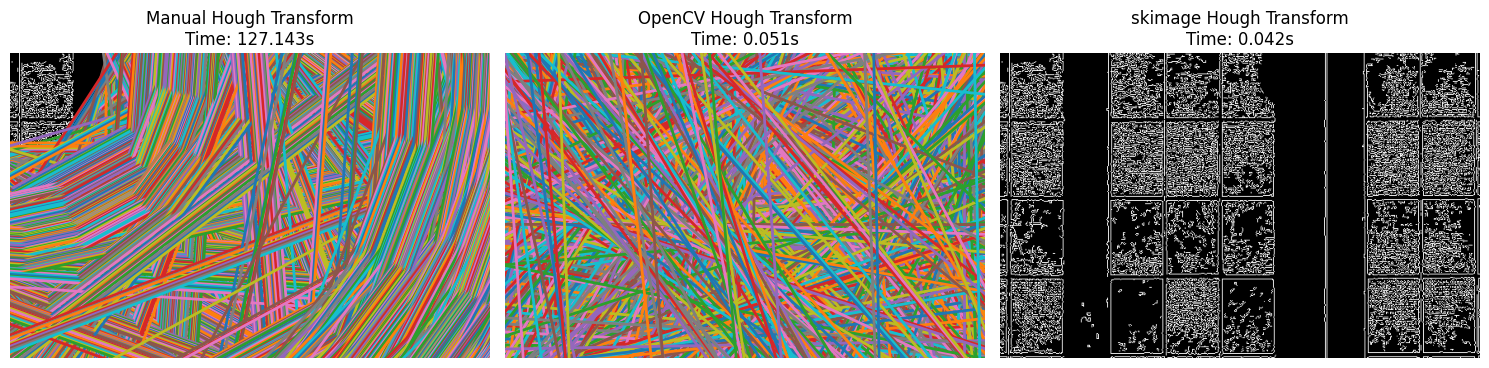

In [57]:
image = cv2.imread("/content/line2.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.Canny(gray_image, 100, 200)

lines_manual, manual_time, lines_cv2, cv2_time, lines_skimage, skimage_time = test_hough_transform(edge_image)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

plot_lines(axes[0], edge_image, lines_manual, f"Manual Hough Transform\nTime: {manual_time:.3f}s")
plot_lines(axes[1], edge_image, lines_cv2, f"OpenCV Hough Transform\nTime: {cv2_time:.3f}s")
plot_lines(axes[2], edge_image, lines_skimage, f"skimage Hough Transform\nTime: {skimage_time:.3f}s")

plt.tight_layout()
plt.show()

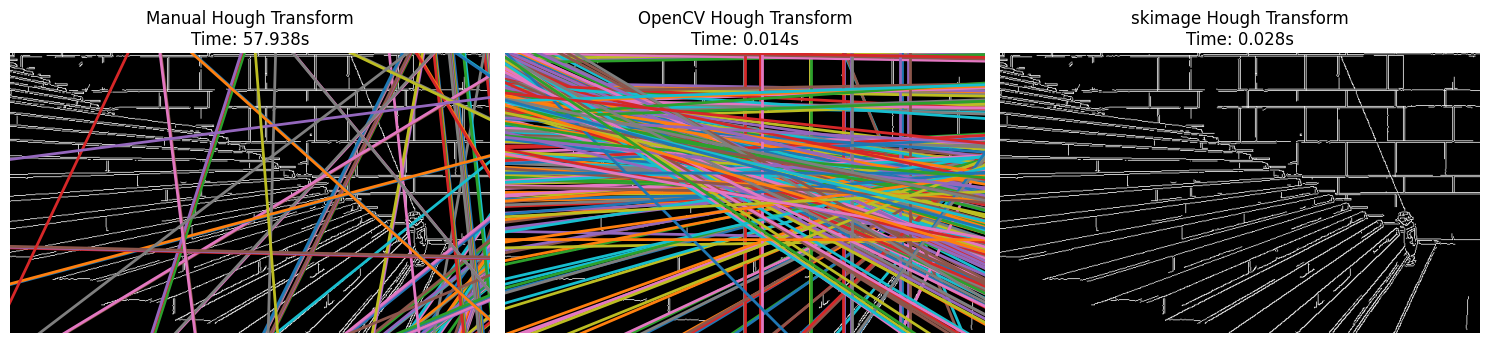

In [58]:
image = cv2.imread("/content/line3.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.Canny(gray_image, 100, 200)

lines_manual, manual_time, lines_cv2, cv2_time, lines_skimage, skimage_time = test_hough_transform(edge_image)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

plot_lines(axes[0], edge_image, lines_manual, f"Manual Hough Transform\nTime: {manual_time:.3f}s")
plot_lines(axes[1], edge_image, lines_cv2, f"OpenCV Hough Transform\nTime: {cv2_time:.3f}s")
plot_lines(axes[2], edge_image, lines_skimage, f"skimage Hough Transform\nTime: {skimage_time:.3f}s")

plt.tight_layout()
plt.show()

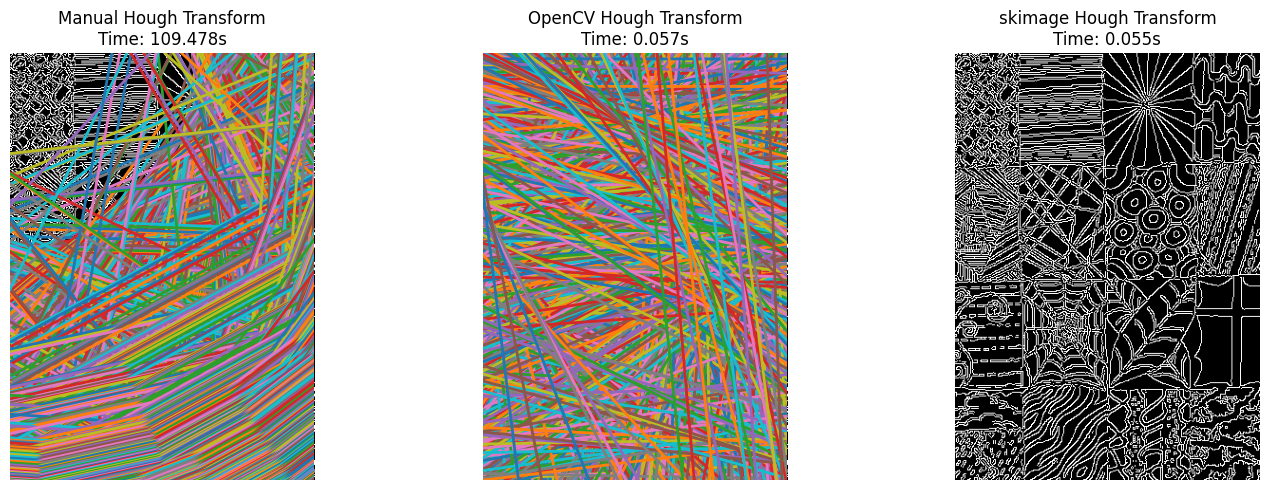

In [60]:
image = cv2.imread("/content/line_mix.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.Canny(gray_image, 100, 200)

lines_manual, manual_time, lines_cv2, cv2_time, lines_skimage, skimage_time = test_hough_transform(edge_image)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

plot_lines(axes[0], edge_image, lines_manual, f"Manual Hough Transform\nTime: {manual_time:.3f}s")
plot_lines(axes[1], edge_image, lines_cv2, f"OpenCV Hough Transform\nTime: {cv2_time:.3f}s")
plot_lines(axes[2], edge_image, lines_skimage, f"skimage Hough Transform\nTime: {skimage_time:.3f}s")

plt.tight_layout()
plt.show()

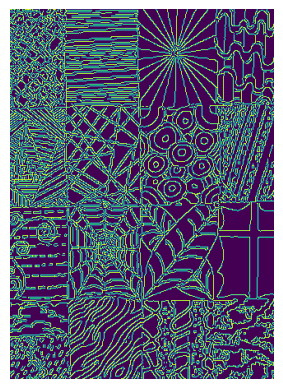

In [64]:
image = cv2.imread("/content/line_mix.jpg")

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.Canny(gray_image, 100, 200)

display_image(edge_image)

In [72]:
def otsu_threshold_manual(image):
  hist, _ = np.histogram(image.ravel(), bins=np.arange(257))
  total_pixels = np.sum(hist)
  total_sum = np.sum(np.arange(256) * hist)
  sumB = 0
  wB = 0
  max_variance = 0
  threshold = 0

  for i in range(256):
    wB += hist[i]
    if wB == 0:
      continue
    wF = total_pixels - wB
    if wF == 0:
      break

    sumB += i * hist[i]
    mB = sumB / wB
    mF = (total_sum - sumB) / wF

    variance = wB * wF * (mB - mF) ** 2

    if variance > max_variance:
      max_variance = variance
      threshold = i

  return threshold

def otsu_threshold_cv2(image):

  _, threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return threshold

def otsu_threshold_skimage(image):
  return filters.threshold_otsu(image)

def test_otsu_threshold(image):
  start_time = time.time()
  manual_threshold = otsu_threshold_manual(image)
  manual_time = time.time() - start_time

  start_time = time.time()
  cv2_threshold = otsu_threshold_cv2(image)
  cv2_time = time.time() - start_time

  start_time = time.time()
  skimage_threshold = otsu_threshold_skimage(image)
  skimage_time = time.time() - start_time

  return manual_threshold, manual_time, cv2_threshold, cv2_time, skimage_threshold, skimage_time

def plot_thresholded_images(image, manual_threshold, cv2_threshold, skimage_threshold):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

  axes[0].imshow(image < manual_threshold, cmap='gray')
  axes[0].set_title(f"Manual Otsu Threshold: {manual_threshold}")

  axes[1].imshow(image < cv2_threshold, cmap='gray')
  axes[1].set_title(f"OpenCV Otsu Threshold: {cv2_threshold}")

  axes[2].imshow(image < skimage_threshold, cmap='gray')
  axes[2].set_title(f"skimage Otsu Threshold: {skimage_threshold}")

  for ax in axes:
    ax.axis('off')

  plt.show()

Manual Otsu Threshold time: 0.007s
OpenCV Otsu Threshold time: 0.001s
skimage Otsu Threshold time: 0.003s


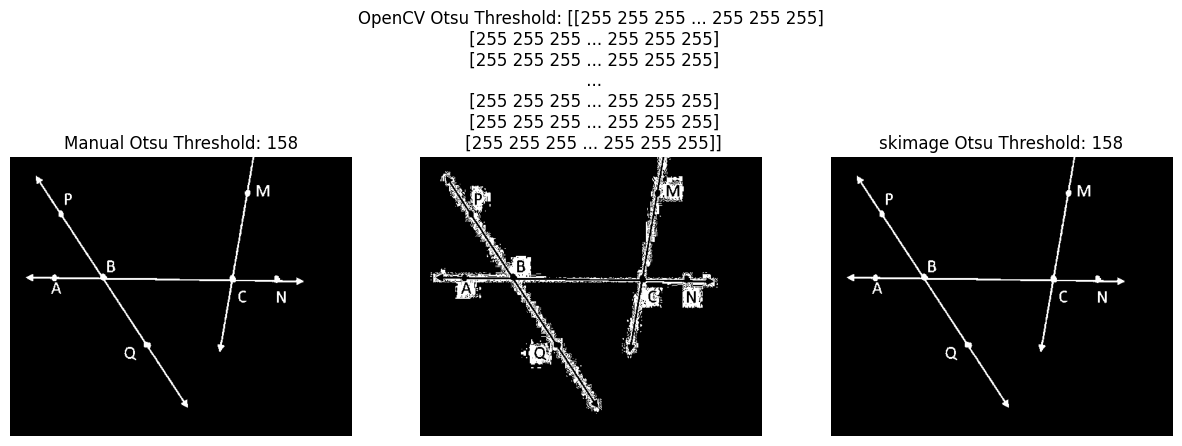

In [90]:
file_path = "/content/line1.jpg"
gray_image = load_image(file_path)

manual_threshold, manual_time, cv2_threshold, cv2_time, skimage_threshold, skimage_time = test_otsu_threshold(gray_image)

print(f"Manual Otsu Threshold time: {manual_time:.3f}s")
print(f"OpenCV Otsu Threshold time: {cv2_time:.3f}s")
print(f"skimage Otsu Threshold time: {skimage_time:.3f}s")

plot_thresholded_images(gray_image, manual_threshold, cv2_threshold, skimage_threshold)

Manual Otsu Threshold time: 0.012s
OpenCV Otsu Threshold time: 0.001s
skimage Otsu Threshold time: 0.002s


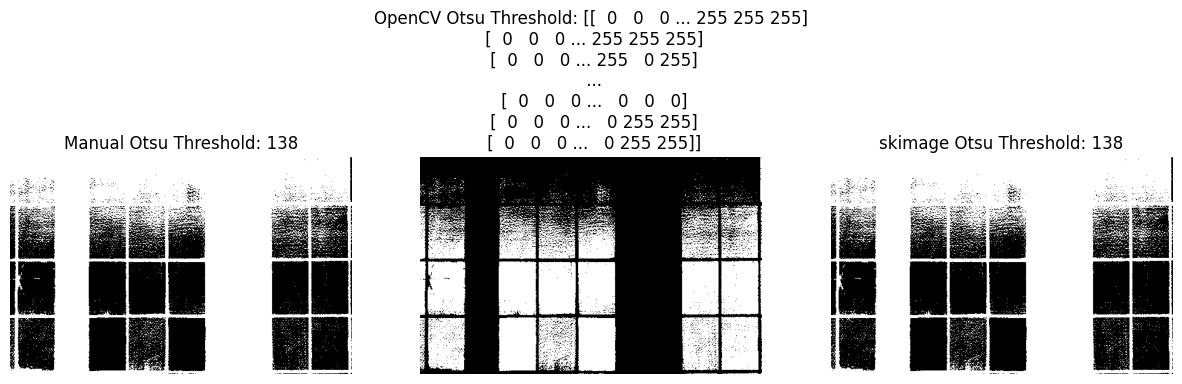

In [91]:
file_path = "/content/line2.jpg"
gray_image = load_image(file_path)

manual_threshold, manual_time, cv2_threshold, cv2_time, skimage_threshold, skimage_time = test_otsu_threshold(gray_image)

print(f"Manual Otsu Threshold time: {manual_time:.3f}s")
print(f"OpenCV Otsu Threshold time: {cv2_time:.3f}s")
print(f"skimage Otsu Threshold time: {skimage_time:.3f}s")

plot_thresholded_images(gray_image, manual_threshold, cv2_threshold, skimage_threshold)

Manual Otsu Threshold time: 0.013s
OpenCV Otsu Threshold time: 0.001s
skimage Otsu Threshold time: 0.003s


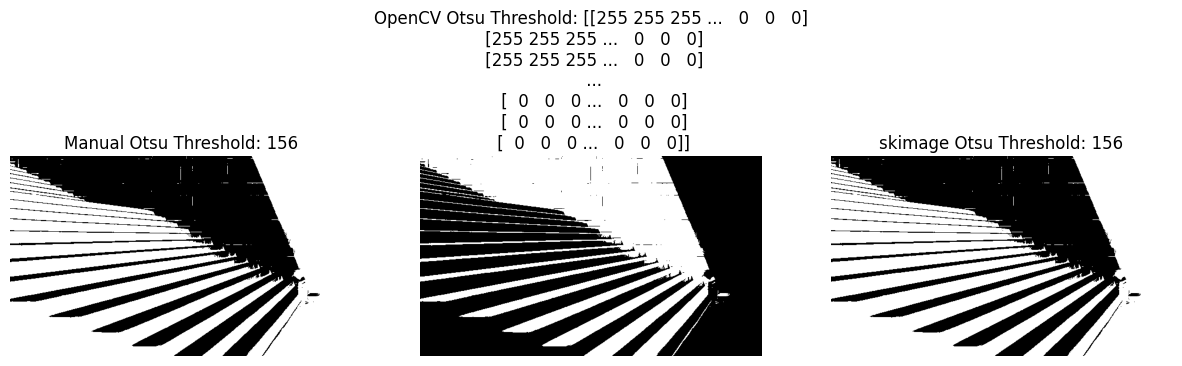

In [92]:
file_path = "/content/line3.jpg"
gray_image = load_image(file_path)

manual_threshold, manual_time, cv2_threshold, cv2_time, skimage_threshold, skimage_time = test_otsu_threshold(gray_image)

print(f"Manual Otsu Threshold time: {manual_time:.3f}s")
print(f"OpenCV Otsu Threshold time: {cv2_time:.3f}s")
print(f"skimage Otsu Threshold time: {skimage_time:.3f}s")

plot_thresholded_images(gray_image, manual_threshold, cv2_threshold, skimage_threshold)

Manual Otsu Threshold time: 0.010s
OpenCV Otsu Threshold time: 0.001s
skimage Otsu Threshold time: 0.001s


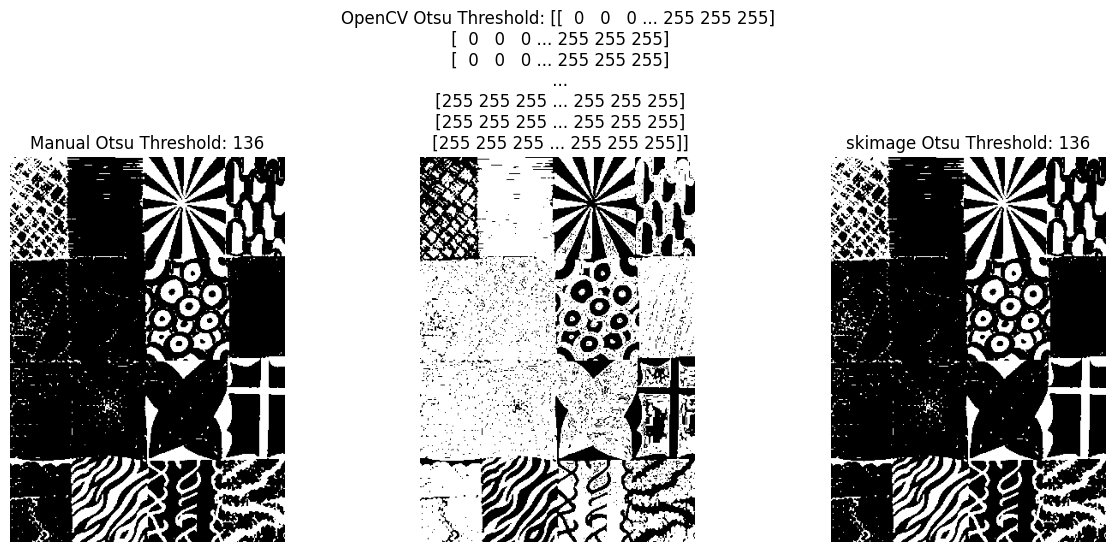

In [93]:
file_path = "/content/line_mix.jpg"
gray_image = load_image(file_path)

manual_threshold, manual_time, cv2_threshold, cv2_time, skimage_threshold, skimage_time = test_otsu_threshold(gray_image)

print(f"Manual Otsu Threshold time: {manual_time:.3f}s")
print(f"OpenCV Otsu Threshold time: {cv2_time:.3f}s")
print(f"skimage Otsu Threshold time: {skimage_time:.3f}s")

plot_thresholded_images(gray_image, manual_threshold, cv2_threshold, skimage_threshold)

Manual Otsu Threshold time: 0.020s
OpenCV Otsu Threshold time: 0.001s
skimage Otsu Threshold time: 0.003s


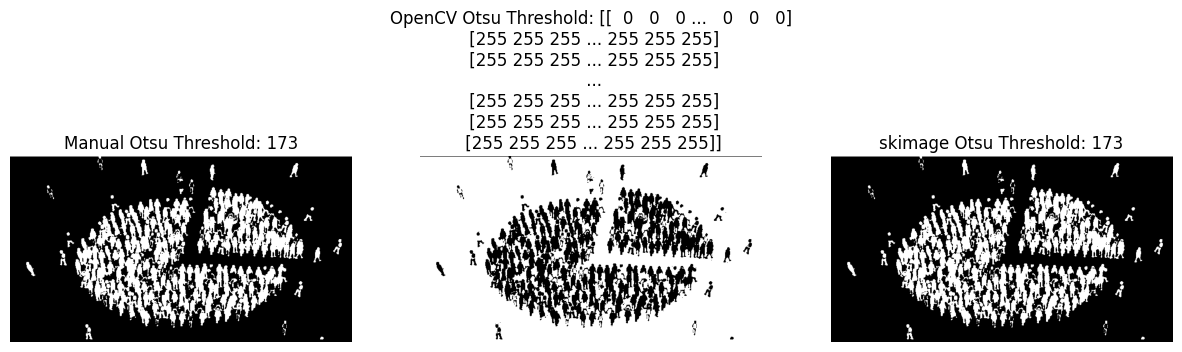

In [94]:
file_path = "/content/seg1.jpg"
gray_image = load_image(file_path)

manual_threshold, manual_time, cv2_threshold, cv2_time, skimage_threshold, skimage_time = test_otsu_threshold(gray_image)

print(f"Manual Otsu Threshold time: {manual_time:.3f}s")
print(f"OpenCV Otsu Threshold time: {cv2_time:.3f}s")
print(f"skimage Otsu Threshold time: {skimage_time:.3f}s")

plot_thresholded_images(gray_image, manual_threshold, cv2_threshold, skimage_threshold)

Manual Otsu Threshold time: 0.029s
OpenCV Otsu Threshold time: 0.001s
skimage Otsu Threshold time: 0.011s


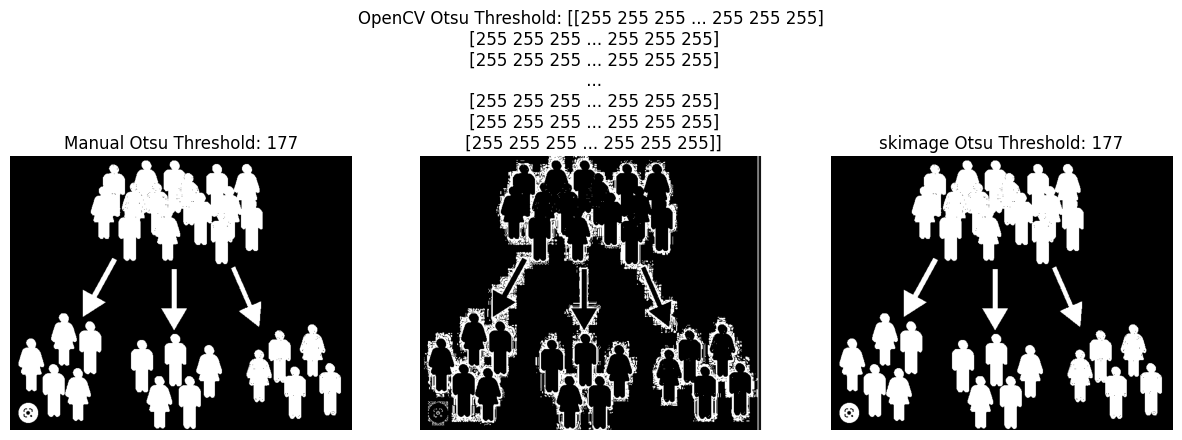

In [95]:
file_path = "/content/seg2.jpg"
gray_image = load_image(file_path)

manual_threshold, manual_time, cv2_threshold, cv2_time, skimage_threshold, skimage_time = test_otsu_threshold(gray_image)

print(f"Manual Otsu Threshold time: {manual_time:.3f}s")
print(f"OpenCV Otsu Threshold time: {cv2_time:.3f}s")
print(f"skimage Otsu Threshold time: {skimage_time:.3f}s")

plot_thresholded_images(gray_image, manual_threshold, cv2_threshold, skimage_threshold)

Manual Otsu Threshold time: 0.022s
OpenCV Otsu Threshold time: 0.000s
skimage Otsu Threshold time: 0.002s


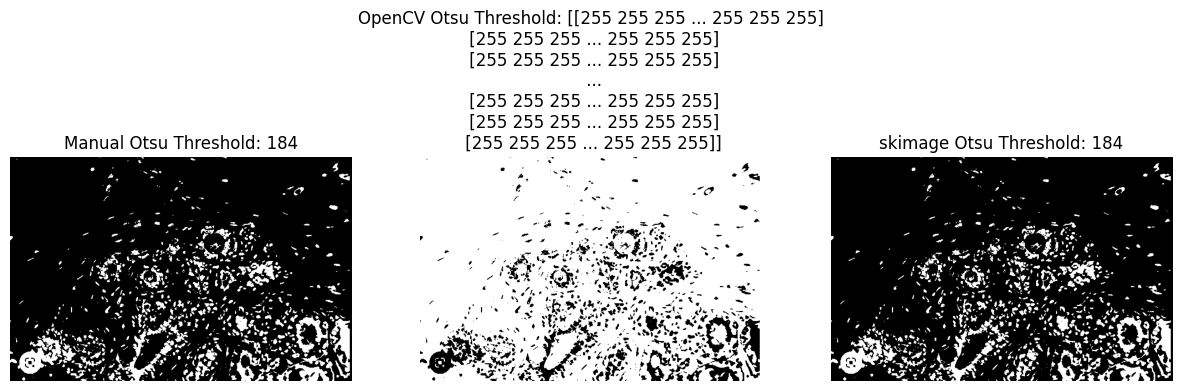

In [96]:
file_path = "/content/seg3.jpg"
gray_image = load_image(file_path)

manual_threshold, manual_time, cv2_threshold, cv2_time, skimage_threshold, skimage_time = test_otsu_threshold(gray_image)

print(f"Manual Otsu Threshold time: {manual_time:.3f}s")
print(f"OpenCV Otsu Threshold time: {cv2_time:.3f}s")
print(f"skimage Otsu Threshold time: {skimage_time:.3f}s")

plot_thresholded_images(gray_image, manual_threshold, cv2_threshold, skimage_threshold)

Manual Otsu Threshold time: 0.016s
OpenCV Otsu Threshold time: 0.001s
skimage Otsu Threshold time: 0.002s


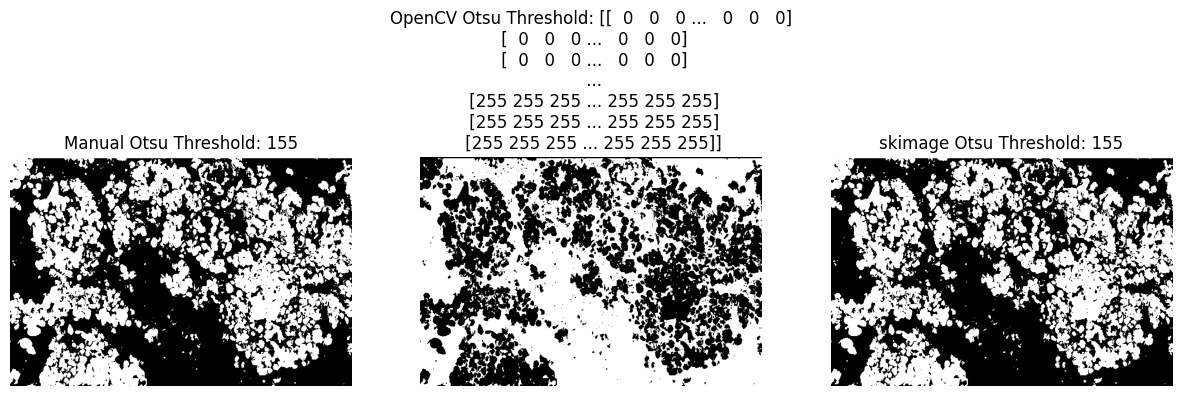

In [97]:
file_path = "/content/seg4.jpg"
gray_image = load_image(file_path)

manual_threshold, manual_time, cv2_threshold, cv2_time, skimage_threshold, skimage_time = test_otsu_threshold(gray_image)

print(f"Manual Otsu Threshold time: {manual_time:.3f}s")
print(f"OpenCV Otsu Threshold time: {cv2_time:.3f}s")
print(f"skimage Otsu Threshold time: {skimage_time:.3f}s")

plot_thresholded_images(gray_image, manual_threshold, cv2_threshold, skimage_threshold)